Analysis plan:


1. Build statistics table for each object type from dataset.
    Objects:
        - games
        - organizations
        - groups of organizations
        - players
        - channels
        - currencies
        - campaigns
2. For more interesing ones, check statistics over time (years/quarters)
3. Examine strange/extreme cases


Games and players are analysed in 2nd notebook.
Prediction is in 3rd notebook.

Database is generated by script: create_database.py

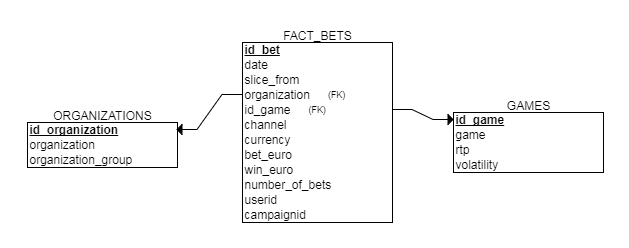

In [1]:
import pandas as pd
import matplotlib as mpl
import sqlite3

%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,7)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
conn = sqlite3.connect('casino.db')
#conn.close()

# General stats

In [3]:
q = """
select sum(number_of_bets) as total_bets
    , count(distinct userid) as users
    , sum(bet_euro) as total_bet_euro
    , cast(sum(bet_euro) as real) / sum(number_of_bets) as avg_bet_euro
    , sum(bet_euro) - sum(win_euro) as total_profit_euro
    , count(distinct id_game) as games_offered
    , cast(sum(bet_euro) - sum(win_euro) as real) / count(distinct userid) as profit_per_user
    , cast(sum(number_of_bets) as real) / count(distinct userid) as bets_per_user
    , sum(bet_euro) / count(distinct userid) as bet_per_user_euro
    , cast(count(*) as real) / count(distinct userid) as sessions_per_user
from FACT_BETS;
"""
df = pd.read_sql(q, conn)
df = df.transpose()
df

,0
total_bets,3552787.000
users,4790.000
total_bet_euro,9153023.815
avg_bet_euro,2.576
total_profit_euro,517462.344
games_offered,42.000
profit_per_user,108.030
bets_per_user,741.709
bet_per_user_euro,1910.861
sessions_per_user,8.569


Session is one record in FACT_BETS table.

### Over years and quarters

In [4]:
q = """
select 
    case 
        when cast(strftime('%m', date) as integer) between 1 and 3 then strftime('%Y', date) || ' Q1'
        when cast(strftime('%m', date) as integer) between 4 and 6 then strftime('%Y', date) || ' Q2'
        when cast(strftime('%m', date) as integer) between 7 and 9 then strftime('%Y', date) || ' Q3'
        else strftime('%Y', date) || ' Q4' end as YQ
    , sum(number_of_bets) as total_bets
    , count(distinct userid) as active_users
    , sum(bet_euro) as total_bet_euro
    , sum(bet_euro) - sum(win_euro) as profit
    , count(distinct organization) as organizations
    , count(distinct id_game) as games_offered
    , cast(sum(bet_euro) - sum(win_euro) as real) / count(distinct userid) as profit_per_user
    , cast(sum(number_of_bets) as real) / count(distinct userid) as bets_per_user
    , cast(count(*) as real) / count(distinct userid) as sessions_per_user
from FACT_BETS
group by YQ
order by date(date);
"""
df = pd.read_sql(q, conn)
df

,YQ,total_bets,active_users,total_bet_euro,profit,organizations,games_offered,profit_per_user,bets_per_user,sessions_per_user
0,2015 Q1,15276,130,21432.675,5189.974,17,9,39.923,117.508,2.177
1,2015 Q2,39356,155,66096.340,3833.742,16,13,24.734,253.910,2.116
2,2015 Q3,103138,280,287940.660,14221.653,33,15,50.792,368.350,3.175
3,2015 Q4,123562,500,303954.697,14283.497,39,17,28.567,247.124,2.804
4,2016 Q1,140310,499,224389.508,33256.201,41,20,66.646,281.182,3.541
5,2016 Q2,284934,616,1020507.644,27168.118,52,23,44.104,462.555,5.950
6,2016 Q3,228161,561,622004.313,47578.200,51,26,84.810,406.704,5.424
7,2016 Q4,426619,757,1246428.349,65403.980,61,30,86.399,563.565,6.764
8,2017 Q1,584837,911,1081551.393,55350.010,66,33,60.757,641.973,7.170
9,2017 Q2,544108,988,1547411.450,138969.494,86,36,140.657,550.717,6.103


Players come back to game over the course of 3 months more often.

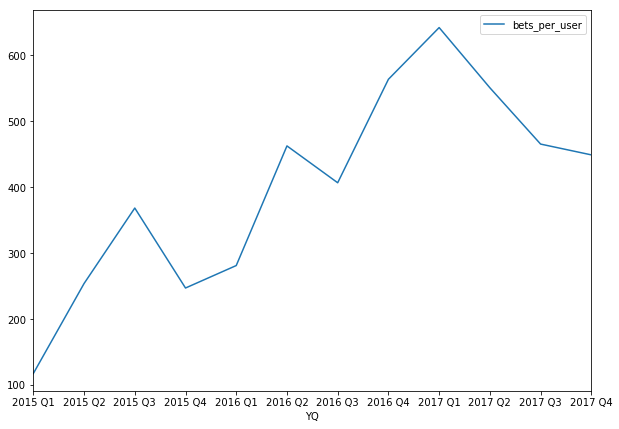

In [5]:
plt = df[['YQ', 'bets_per_user']].plot(x=df['YQ'], xticks=range(len(df['YQ'])))

Players play more over time

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B3CF978>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000B46AF60>], dtype=object)

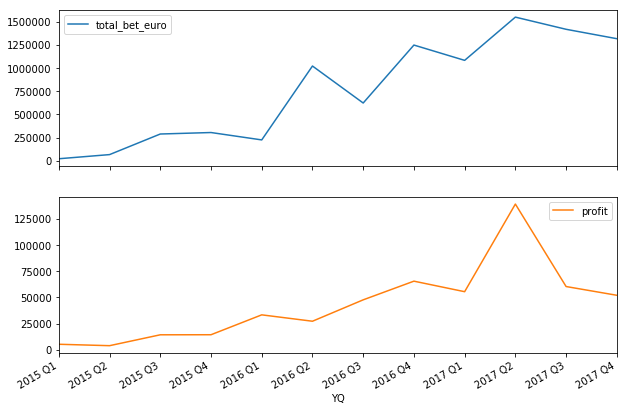

In [6]:
df[['YQ', 'total_bet_euro', 'profit']].plot(x=df['YQ'], xticks=range(len(df['YQ'])), subplots=True)

Volume (total bet euro) increase more stadily than profit because of games volatility.

*End of 2017 has small number of datapoints.

### Over days of the week

In [7]:
q = """
select 
    case 
        when cast(strftime('%w', date) as integer) = 0 then 'Sunday'
        when cast(strftime('%w', date) as integer) = 1 then 'Monday'
        when cast(strftime('%w', date) as integer) = 2 then 'Tuesday'
        when cast(strftime('%w', date) as integer) = 3 then 'Wednesday'
        when cast(strftime('%w', date) as integer) = 4 then 'Thursday'
        when cast(strftime('%w', date) as integer) = 5 then 'Friday'
        else 'Saturday' end as Day_of_week
    , sum(number_of_bets) as total_bets
    , count(distinct userid) as active_users
    , sum(bet_euro) as total_bet_euro
    , sum(bet_euro) - sum(win_euro) as profit_euro
    , cast(sum(bet_euro) - sum(win_euro) as real) / count(distinct userid) as profit_per_user
    , cast(sum(number_of_bets) as real) / count(distinct userid) as bets_per_user
    , cast(count(*) as real) / count(distinct userid) as sessions_per_user
from FACT_BETS
group by Day_of_week
order by date(date);
"""
df = pd.read_sql(q, conn)
df['%_of_all_bet_euro'] = df['total_bet_euro']*100 / sum(df['total_bet_euro'])
df['%_of_all_bets'] = df['total_bets']*100 / sum(df['total_bets'])
df

,Day_of_week,total_bets,active_users,total_bet_euro,profit_euro,profit_per_user,bets_per_user,sessions_per_user,%_of_all_bet_euro,%_of_all_bets
0,Sunday,436025,1049,759584.625,57454.575,54.771,415.658,3.858,8.299,12.273
1,Monday,471002,1505,1486010.564,7746.240,5.147,312.958,3.755,16.235,13.257
2,Tuesday,529202,1679,1435047.895,59881.655,35.665,315.189,3.811,15.678,14.895
3,Wednesday,553321,1689,1483853.605,96936.426,57.393,327.603,3.920,16.212,15.574
4,Thursday,558452,1714,1413217.555,96758.167,56.452,325.818,4.072,15.440,15.719
5,Friday,547214,1661,1544345.248,122281.369,73.619,329.449,4.014,16.873,15.402
6,Saturday,457571,1191,1030964.322,76403.912,64.151,384.191,3.929,11.264,12.879


Sunday players make more bets (bets_per_user) but also plays smaller stakes (%_of_all_bet_euro).

Monday is the least popular day for playing (active_users, %_of_all_bet_euro, %_of_all_bets).

Most money is betted in Friday (%_of_all_bet_euro) so is biggest net profit (profit_euro).

I assume that players are from different time zones so grouping by hours doesn't make sense.

# Organizations stats

In [8]:
q = """
select organization
    , sum(number_of_bets) as total_bets
    , count(distinct userid) as users
    , sum(bet_euro) as total_bet_euro
    , sum(bet_euro) - sum(win_euro) as org_profit
    , count(distinct id_game) as games_offered
    , cast(sum(bet_euro) - sum(win_euro) as real) / count(distinct userid) as profit_per_user
    , cast(sum(number_of_bets) as real) / count(distinct userid) as bets_per_user
    , cast(count(*) as real) / count(distinct userid) as sessions_per_user
    , julianday(date('now')) - julianday(min(date(date))) as days_since_start
from FACT_BETS
group by organization
order by total_bets desc;
"""
df = pd.read_sql(q, conn)
df['%_of_all_bet_euro'] = df['total_bet_euro']*100 / sum(df['total_bet_euro'])
df['%_of_all_bets'] = df['total_bets']*100 / sum(df['total_bets'])
df.head(10)

,organization,total_bets,users,total_bet_euro,org_profit,games_offered,profit_per_user,bets_per_user,sessions_per_user,days_since_start,%_of_all_bet_euro,%_of_all_bets
0,organization_300,301776,757,470762.394,44588.148,41,58.901,398.647,5.679,1126.000,5.143,8.494
1,organization_267,273486,418,1087929.184,64034.486,41,153.193,654.273,8.067,1126.000,11.886,7.698
2,organization_366,209357,149,197847.700,14026.211,33,94.136,1405.081,12.510,411.000,2.162,5.893
3,organization_446,154148,138,200046.773,20772.166,35,150.523,1117.014,15.449,874.000,2.186,4.339
4,organization_48,149338,164,223157.938,22104.655,36,134.784,910.598,11.372,922.000,2.438,4.203
5,organization_479,144562,133,81564.135,6868.196,39,51.641,1086.932,10.120,1124.000,0.891,4.069
6,organization_102,136038,206,297808.993,763.134,33,3.705,660.379,10.340,796.000,3.254,3.829
7,organization_484,133055,133,329654.437,13583.684,31,102.133,1000.414,8.481,384.000,3.602,3.745
8,organization_462,132476,127,591455.108,32904.802,29,259.093,1043.118,10.150,1077.000,6.462,3.729
9,organization_427,122124,107,73907.959,3090.297,36,28.881,1141.346,9.037,873.000,0.807,3.437


organization_300 and organization_267 have most share of total bets. organization_300 has bigger share of bets but less share of bet euro (volume).

# Organization groups stats

In [9]:
q = """
select organization_group
    , sum(number_of_bets) as total_bets
    , count(distinct userid) as users
    , sum(bet_euro) as total_bet_euro
    , sum(bet_euro) - sum(win_euro) as total_profit
    , count(distinct fb.organization) as organizations
    , cast(sum(bet_euro) - sum(win_euro) as real) / count(distinct userid) as profit_per_user
    , cast(sum(number_of_bets) as real) / count(distinct userid) as bets_per_user
    , cast(count(*) as real) / count(distinct userid) as sessions_per_user
from FACT_BETS as fb
join ORGANIZATIONS as o on o.organization = fb.organization
group by o.organization_group
order by total_bets desc;
"""
df = pd.read_sql(q, conn)
df['%_of_all_bet_euro'] = df['total_bet_euro']*100 / sum(df['total_bet_euro'])
df['%_of_all_bets'] = df['total_bets']*100 / sum(df['total_bets'])
df.head(10)

,organization_group,total_bets,users,total_bet_euro,total_profit,organizations,profit_per_user,bets_per_user,sessions_per_user,%_of_all_bet_euro,%_of_all_bets
0,group_13,390412,543,883158.509,64743.360,11,119.233,718.991,8.446,9.649,10.989
1,group_12,373302,413,366534.605,27767.140,4,67.233,903.879,10.240,4.005,10.507
2,group_50,301776,757,470762.394,44588.148,1,58.901,398.647,5.679,5.143,8.494
3,group_48,273486,418,1087929.184,64034.486,1,153.193,654.273,8.067,11.886,7.698
4,group_39,250954,262,527600.693,9589.639,2,36.602,957.840,11.076,5.764,7.064
5,group_64,209357,149,197847.700,14026.211,1,94.136,1405.081,12.510,2.162,5.893
6,group_21,176200,290,293176.817,6992.618,8,24.112,607.586,9.069,3.203,4.959
7,group_24,165107,181,201377.873,20224.452,7,111.737,912.193,8.923,2.200,4.647
8,group_78,150610,150,608361.034,32864.044,3,219.094,1004.067,9.333,6.647,4.239
9,group_57,144562,133,81564.135,6868.196,1,51.641,1086.932,10.120,0.891,4.069


# Channels stats

In [10]:
q = """
select channel
    , sum(number_of_bets) as total_bets
    , count(distinct userid) as users
    , sum(bet_euro) as total_bet_euro
    , sum(bet_euro) - sum(win_euro) as profit
    , count(distinct organization) as organizations
    , cast(sum(bet_euro) - sum(win_euro) as real) / count(distinct userid) as profit_per_user
    , cast(sum(number_of_bets) as real) / count(distinct userid) as bets_per_user
    , cast(count(*) as real) / count(distinct userid) as sessions_per_user
from FACT_BETS
group by channel;
"""
df = pd.read_sql(q, conn)
df['%_of_all_bet_euro'] = df['total_bet_euro']*100 / sum(df['total_bet_euro'])
df['%_of_all_bets'] = df['total_bets']*100 / sum(df['total_bets'])
df

,channel,total_bets,users,total_bet_euro,profit,organizations,profit_per_user,bets_per_user,sessions_per_user,%_of_all_bet_euro,%_of_all_bets
0,DESKTOP,2538366,4110,7408043.638,420380.405,132,102.282,617.607,7.541,80.935,71.447
1,MOBILE,1014421,1546,1744980.177,97081.939,91,62.796,656.158,6.502,19.065,28.553


Mobile players play lower stakes on average

# Currencies stats

In [11]:
q = """
select currency
    , sum(number_of_bets) as total_bets
    , count(distinct userid) as users
    , sum(bet_euro) as total_bet_euro
    , sum(bet_euro) - sum(win_euro) as profit
    , count(distinct organization) as organizations
    , cast(sum(bet_euro) - sum(win_euro) as real) / count(distinct userid) as profit_per_user
    , cast(sum(number_of_bets) as real) / count(distinct userid) as bets_per_user
    , cast(count(*) as real) / count(distinct userid) as sessions_per_user
from FACT_BETS
group by currency
order by total_bets desc;
"""
df = pd.read_sql(q, conn)
df['%_of_all_bet_euro'] = df['total_bet_euro']*100 / sum(df['total_bet_euro'])
df['%_of_all_bets'] = df['total_bets']*100 / sum(df['total_bets'])
df

,currency,total_bets,users,total_bet_euro,profit,organizations,profit_per_user,bets_per_user,sessions_per_user,%_of_all_bet_euro,%_of_all_bets
0,EUR,3296891,4414,7768848.186,396292.748,121,89.781,746.917,8.616,84.877,92.797
1,SEK,170791,184,909119.592,80815.507,37,439.215,928.212,10.701,9.932,4.807
2,NOK,41277,59,30978.304,2713.497,23,45.991,699.610,9.288,0.338,1.162
3,TRY,25568,9,395982.495,30517.557,7,3390.840,2840.889,18.111,4.326,0.720
4,GBP,10545,74,22315.336,3959.518,21,53.507,142.500,2.703,0.244,0.297
5,USD,6283,31,25076.571,2922.618,17,94.278,202.677,3.097,0.274,0.177
6,CAD,399,5,141.098,22.725,3,4.545,79.800,1.600,0.002,0.011
7,CZK,269,1,243.744,77.332,1,77.332,269.000,2.000,0.003,0.008
8,AUD,245,2,69.957,28.165,2,14.083,122.500,3.000,0.001,0.007
9,NZD,190,3,40.463,8.494,3,2.831,63.333,1.667,0.000,0.005


Player using SEK play higher stakes thank EUR player on average

# Campaign stats

In [12]:
q = """
select 
    campaignid
    , count(distinct id_game)
    , sum(number_of_bets) as total_bets
    , count(distinct userid) as users
    , sum(bet_euro) as total_bet_euro
    , sum(bet_euro) - sum(win_euro) as profit
    , count(distinct organization) as organizations
    , count(distinct id_game) as games_offered
    , cast(sum(bet_euro) - sum(win_euro) as real) / count(distinct userid) as profit_per_user
    , cast(sum(number_of_bets) as real) / count(distinct userid) as bets_per_user
    , cast(count(*) as real) / count(distinct userid) as sessions_per_user
from FACT_BETS
where campaignid <> 0
group by campaignid
order by total_bets desc;
"""
df = pd.read_sql(q, conn)
df['%_of_all_bet_euro'] = df['total_bet_euro']*100 / sum(df['total_bet_euro'])
df['%_of_all_bets'] = df['total_bets']*100 / sum(df['total_bets'])
df.head(10)

,campaignid,count(distinct id_game),total_bets,users,total_bet_euro,profit,organizations,games_offered,profit_per_user,bets_per_user,sessions_per_user,%_of_all_bet_euro,%_of_all_bets
0,1709211300300300187,1,11382,65,11172.436,1127.878,20,1,17.352,175.108,1.769,9.164,9.658
1,1711081358230400196,1,10548,13,2058.650,197.328,3,1,15.179,811.385,6.769,1.689,8.951
2,1710260759240200174,1,10374,51,10850.522,427.537,22,1,8.383,203.412,2.157,8.900,8.803
3,1709211304460700263,1,9268,55,14362.172,929.258,20,1,16.896,168.509,1.764,11.781,7.864
4,1706281410580800187,1,7141,24,1619.345,-6.279,9,1,-0.262,297.542,1.917,1.328,6.060
5,1707251050160300184,1,6982,45,9450.378,1314.613,17,1,29.214,155.156,2.022,7.752,5.925
6,1708241422090300184,3,6264,32,9072.988,357.266,14,3,11.165,195.750,2.500,7.442,5.315
7,1711161222400000174,1,5084,20,1377.550,-134.010,1,1,-6.701,254.200,2.950,1.130,4.314
8,1708241424010100188,3,4389,24,4306.950,1170.440,5,3,48.768,182.875,2.167,3.533,3.724
9,1710260759420000185,1,4362,35,6201.535,-265.767,12,1,-7.593,124.629,2.371,5.087,3.701


# Consistency check

Any user in multiple organizations? NO

In [13]:
q = """
select userid, count(distinct organization) as org_cnt 
from FACT_BETS
group by userid
having org_cnt > 1
"""
df = pd.read_sql(q, conn)
len(df)

0

Any organization in multiple groups? NO

In [14]:
q = """
select organization, count(distinct organization_group) as group_cnt 
from ORGANIZATIONS
group by organization
having group_cnt > 1
"""
df = pd.read_sql(q, conn)
len(df)

0